# Your Details

Your Name:Divya acharya

Your ID Number:23283742

# Etivity 3 - Task 2: Use Tensorflow and Keras to build a model for sign-language digit classification using transfer learning based on the MobileNet CNN model and then do fine-tuning.

In the previous task you developed and used CNN models using TensorFlow Keras libraries. In this notebook you will carry out transfer learning by modifying the MobileNet model [1] trained on the ImageNet [2] database and then perform fine-tuning to try and imporve the performance. 


By the end of this notebook, you'll be able to: 

* Load a pre-trained MobileNet model using the TensorFlow/Keras framework.
* Replace the last layer from 1000 nodes down to 10 nodes for sign-language digit classification.
* Modify the trainable paramters to false except for the last layer.
* Fit the model to the training set.
* Analyse the model perfromance.
* Perform fine-tuning by making more layer parameters trainable and retrain the model.
* Analyse the fine-tuned model performance.
* Store your model architecture.


### Important Note on Submission 

There are code exercises to complete in this task. Use the notes provided to help you build understanding. Insert your code entries into the cell areas marked with the 'enter code here' text as below, so that grading can easily be assessed.

\### **ENTER CODE HERE**

Please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.


Let's get started!

## Table of Contents
- [1- Packages and Dataset](#1)
    - [1.1 - Prepare and load dataset](#1-1)
- [2 - Apply Transfer Learning  on the MobileNet CNN model](#2)
    - [2.1 - Import the MobileNet model](#2-1)
    - [2.2 - Modify the MobileNet model for sign-digit classification](#2-2)
- [3 - Compile and train the MobileNet model for sign-language digit classification](#3)
- [4 - Analyze model performance](#4)
    - [4.1 - Plot the model loss and accuracy metrics](#4-1)
    - [4.2 - Generate the predictions and plot the confusion matrix](#4-2)
- [5 - Let's do some fine-tuning](#5)
    - [5.1 - Make all the model layers trainable](#5-1)
    - [5.2 - Fine-tune from a suitable layer](#5-2)
    - [5.2 - Compile and train the model](#5-3)
- [6 - Analyze model performance](#6)
    - [6.1 - Plot the model loss and accuracy metrics](#6-1)
    - [6.2 - Generate the predictions and plot the confusion matrix](#6-2)
    - [6.3 - Results analysis - commentary](#6-3)
- [7 - Save the model and weights](#7)

<a name='1'></a>
## 1- Packages and Dataset

In [1]:
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import numpy as np
import itertools
import tensorflow as tf
import time
from keras_cnn_app_utils import *
            
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

# Measure time taken
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

**Use this code cell only if you have a GPU**

In [2]:
print("Is there a GPU available: "),
print(tf.config.experimental.list_physical_devices("GPU"))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Is there a GPU available: 
[]
Num GPUs Available:  0


<a name='1-1'></a>
### 1.1 Prepare and load dataset

For this exericise, we will use a sign-language digit dataset that was created by high-school students [3]. The dataset consist of example images as seen in Figure 1 representing the sign-language for digits from 0 to 9.

<img src="images/Sign-Digits_dataset_preview.png" style="width:650px;height:300px;">
<caption><center> <b>Figure 1</b>: <b>Example sign-language images representing digits 0-9.</b><br></center></caption>
 
**Details of dataset:**
   * Image size: 100 x 100 pixels
   * Color space: RGB
   * Number of classes: 10 (Digits: 0-9)
   * Number of images: 2062
   
   
**Note**: As all of the images are contained within a single 'dataset' folder, we first have to create separate train/valid/test sets using the cell below. 

In [3]:
# Create train, valid and test image sets within the Sign Language Dataset directory
os.chdir('./Sign-Language-Digits-Dataset')
if os.path.isdir('train') is False:
    os.makedirs('train')
if os.path.isdir('valid') is False:
    os.makedirs('valid')
if os.path.isdir('test') is False:
    os.makedirs('test')

# Move all class folder images from Dataset into train folder
if os.path.isdir('train/0') is False:
    for j in range(0,10):
        shutil.move('Dataset/'+ str(j), 'train/')  

# Make class folders for the valid data set
if os.path.isdir('valid/0') is False:
    os.chdir('valid')
    for j in range(0,10):
         os.makedirs(str(j))
    os.chdir('../')
    
# Make class folders for the test data set
if os.path.isdir('test/0') is False:
    os.chdir('test')
    for j in range(0,10):
         os.makedirs(str(j))
    os.chdir('../')

# Create valid and test data sets by randomly taking samples from the train set
if not glob.glob('./valid/0/IMG_*.jpg'):
    os.chdir('train')
    for j in range(0,10):
        os.chdir(str(j))
        for i in random.sample(glob.glob('*'), 30):
            shutil.move(i, '../../valid/'+str(j))
        for i in random.sample(glob.glob('*'), 5):
            shutil.move(i, '../../test/'+str(j))
        os.chdir('../')
    os.chdir('../')
os.chdir('../')
#  Make sure we are in the current notebook home directory
os.getcwd()

'/Users/adipawar/Aditya/Data Science/Deep 3 task2'

In [4]:
train_path = 'Sign-Language-Digits-Dataset/train'
valid_path = 'Sign-Language-Digits-Dataset/valid'
test_path = 'Sign-Language-Digits-Dataset/test'

**Preprocess images based on mobilenet and use TensorFlow's ImageDataGenerator to organise images into batch sizes of 10**

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [6]:
assert train_batches.n == 1712
assert valid_batches.n == 300
assert test_batches.n == 50
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 10

**Let's look at some of the images in the train dataset**

In [7]:
# Grab the images and labels from the training batch (10)
imgs, labels = next(train_batches)

In [8]:
# This function plots images in the form of a grid with 1 row and 10 colummns (from tensorflow site)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

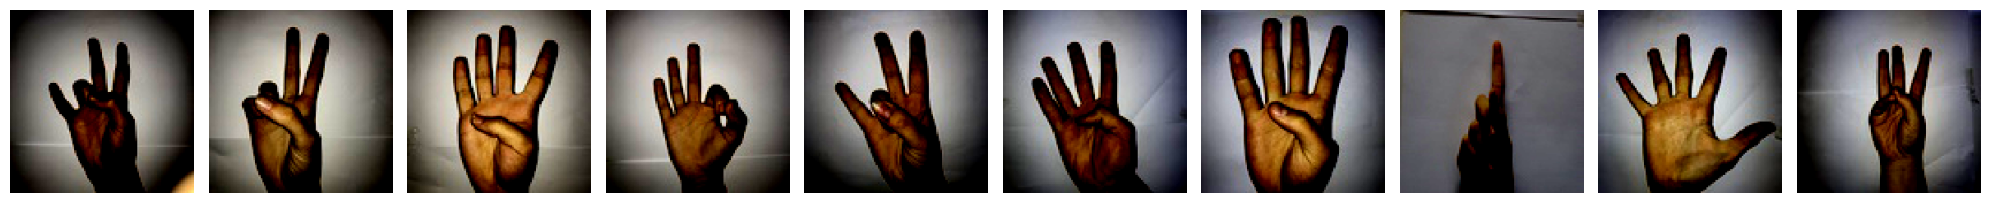

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [9]:
plotImages(imgs)
print(labels)

<a name='2'></a>
## 2 - Apply Transfer Learning  on the MobileNet CNN model

<a name='2-1'></a>
### 2.1 Import the MobileNet CNN model and report on the model structure

1. Import the MobileNet model from Keras. Note, an internet connection is needed to download this model.
2. Report on the model.summary().
3. Report on the model type - notice that this is a functional model.
4. Check how many layers in this model.

In [10]:
mobilenet = tf.keras.applications.mobilenet.MobileNet()

In [11]:
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [12]:
type(mobilenet)

keras.src.engine.functional.Functional

In [13]:
len(mobilenet.layers)

91

<a name='2-2'></a>
### 2.2 Modify the MobileNet  model for sign-digit classification and report on the model structure

This is a functional API Keras model for ImageNet classification (1000 classes). We need 10 class outputs for our sign-language digit classification and so need to build a new model using the same layers as in MobileNet upto the last layer.

1. (a) Create a new  model thats uses the MobileNet model upto to the last layer. (b) Add a final layer with 10 units using a softmax activation (c) Show the new model structure.
2. (a) Make all the layers upto the final layer not trainable and (b) Show the model structure that gives the number of trainable weights.

In [40]:
### ENTER CODE HERE
# 1(a): Create a model that uses all the layers in the MobileNet model except for the last layer. 
# 1(b): Add a new final layer that has 10 units and a softmax activation.
# 1(c): Report on the model structure.

from tensorflow.keras.models import Model

mobilenet_prefinal = mobilenet.layers[-2].output

# Add a new final layer with 10 units and softmax activation
mobilenet_final = Dense(10, activation='softmax')(mobilenet_prefinal)

# Create a new model
model = Model(inputs=mobilenet.input, outputs=mobilenet_final)

# Report on the model structure
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [17]:
### ENTER CODE HERE 
# 2(a): Make all layers not trainable
# 2(b): Report on model structure - showing the number of trainable parameters

for layer in model.layers[:-1]:
    layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

<a name='3'></a>
## 3 - Train the MobileNet model for sign-language digit classification

###  Compile the CNN model and train the network

1. Use **model.compile()** to compile the CNN model using Adam optimization and a learning_rate = 0.0001. Also specify categorical_crossentropy as the loss function and report on the accuracy metric.


2. Use **history=model.fit()** with inputs 'x=train_batches' and 'steps_per_epoch=len(train_batches)'. Also set 'validation_data=valid_batches' as input, so that you can investigate the valid set loss/accuracy figure. This will be useful in determining the performance of this model. Use 10 epochs to initially train the network.

In [18]:
### ENTER CODE HERE (compile the model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
### ENTER CODE HERE (train the model)
# If you want to use the GPU to train the model quicker - insert this line before the training - "with tf.device('/GPU:0'):"
history = model.fit(x=train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches, epochs=10)

Epoch 1/10
172/172 [==============================] - 13s 74ms/step - loss: 2.7295 - accuracy: 0.2085 - val_loss: 1.8939 - val_accuracy: 0.3933
Epoch 2/10
172/172 [==============================] - 12s 69ms/step - loss: 1.4859 - accuracy: 0.4866 - val_loss: 1.2585 - val_accuracy: 0.5567
Epoch 3/10
172/172 [==============================] - 12s 68ms/step - loss: 1.0273 - accuracy: 0.6612 - val_loss: 0.9767 - val_accuracy: 0.6500
Epoch 4/10
172/172 [==============================] - 12s 71ms/step - loss: 0.8063 - accuracy: 0.7301 - val_loss: 0.7816 - val_accuracy: 0.7400
Epoch 5/10
172/172 [==============================] - 12s 71ms/step - loss: 0.6543 - accuracy: 0.7856 - val_loss: 0.6582 - val_accuracy: 0.7867
Epoch 6/10
172/172 [==============================] - 12s 69ms/step - loss: 0.5587 - accuracy: 0.8254 - val_loss: 0.5872 - val_accuracy: 0.8067
Epoch 7/10
172/172 [==============================] - 12s 70ms/step - loss: 0.4933 - accuracy: 0.8475 - val_loss: 0.5280 - val_accuracy:

<a name='4'></a>
## 4 - Analyze model performance: Loss, accuracy, predictions and confusion matrix

<a name='4-1'></a>
### 4.1 **Plot** the model loss and accuracy metrics in the code cell below

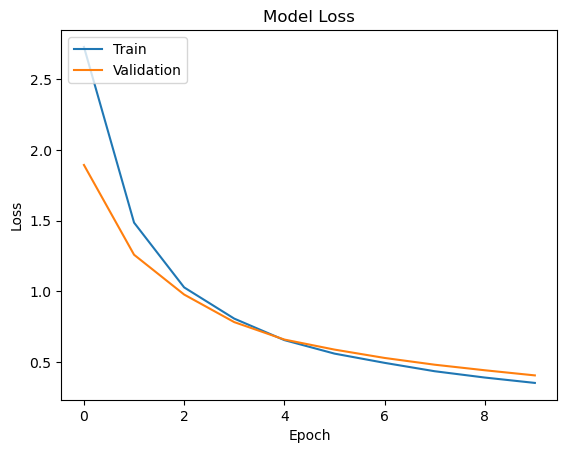

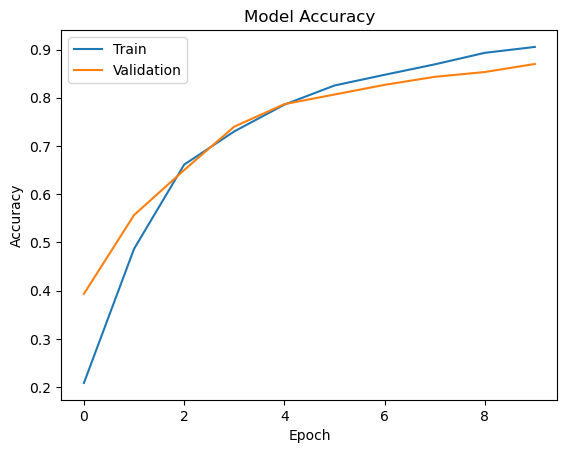

In [20]:
### ENTER CODE HERE

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**What** do these plots reveal about the model performance?
**Enter your observations in the markdown cell**

#### ENTER COMMENT HERE
The training logs show how the model learns and improves over ten rounds of training. Here's what they tell us:

1. **Loss Decrease**: The model gets better at making predictions because the loss, or error, goes down as it learns from the data.

2. **Accuracy Increase**: The model becomes more accurate with each round of training, meaning it gets better at correctly recognizing sign language digits.

3. **Good Generalization**: The model performs well on new, unseen data (validation set), indicating it's not just memorizing the training examples but truly understanding how to classify sign language digits.

4. **Overall Good Performance**: The model does well on both the training and validation sets, suggesting it's capable of accurately recognizing sign language digits.

In simple terms, the training logs show that the model learns and improves over time, becoming better at recognizing sign language digits accurately.

<a name='4-2'></a>
### 4.2 Generate the predictions and plot the confusion matrix

1. Generate the predictions by using the **model.predict()** function call on the test_batches dataset.

In [21]:
### ENTER CODE HERE
predictions = model.predict(test_batches)

5/5 [==============================] - 1s 65ms/step


2. Plot the performance of the predictions usign a **confusion matrix**. Use the sklearn.metrics confusion_matrix() command with the test_batches correct predictions and predictions from the trained model as inputs. Plot the confusion matrix by labeling the plot correctly and analyze the result - what does this plot inform you about the level of model performance?
**Note**: You can use the plot_confusion_matrix() routine in the keras_cnn_app_utils.py file.

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 1 0 3 1 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 2 0 0 0 0 0 1 2]]


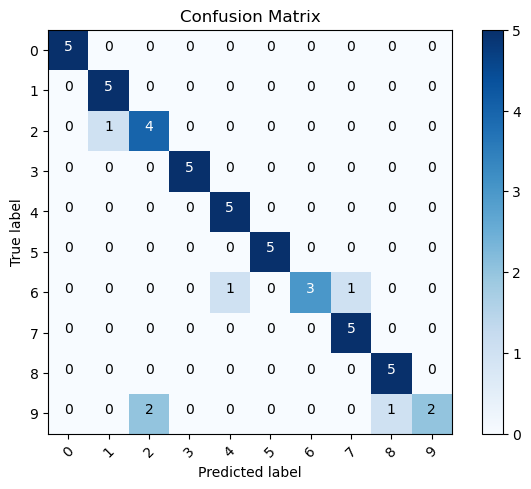

In [31]:
### ENTER CODE HERE

predicted_classes = np.argmax(predictions, axis=1) 

conf_matrix = confusion_matrix(test_batches.classes, predicted_classes)

plot_confusion_matrix(conf_matrix, [i for i in range(10)], title='Confusion Matrix')

**What story does the confusion matrix tell** - Place your commentary on the confusion matrix in the markdown cell below.

#### ENTER COMMENT HERE
The confusion matrix associated with the MobileNet model reveals the model's performance in categorizing images into different classes. Here's what the confusion matrix indicates:

- Along the diagonal, it shows the count of correctly classified samples for each class. For instance, a value of 5 at position (0, 0) signifies that 5 samples with the actual class label 0 were accurately identified as class 0.

- Off-diagonal elements represent misclassifications, such as a value of 1 at position (2, 1), indicating that 1 sample with the true class label 2 was incorrectly classified as class 1.

- A higher concentration of values along the diagonal suggests effective classification, whereas non-zero values off-diagonal indicate misclassifications.

In summary, the confusion matrix offers insights into the MobileNet model's ability to classify images, highlighting areas where it may struggle to accurately identify certain classes.

<a name='5'></a>
## 5 - Let's do some fine-tuning

Fine-tuning refers to using the weights of an already trained network as the starting values for training a new network:

<a name='5-1'></a>
### 5.1 Make all the model layers trainable
First, lets make all the model layers completely trainable and print out the number of layers in this base model.

In [32]:
model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  91


<a name='5-2'></a>
### 5.2 Fine-tune starting from a suitable layer

As there are 91 layers in this model, we will decide to fine-tune the network from layer 80 onwards. In order to do this you will need to freeze all the layer parameters (weights + biases) up to and including layer 80 so as not to make them trainable.

**Hint**: Use 'layer.trainable = False'

This will allow us to retrain only the final 11 layers in the CNN model.

In [33]:
### ENTER CODE HERE
for layer in mobilenet.layers[:80]:
    layer.trainable = False

<a name='5-3'></a>
### 5.3  Compile the model and train the network

1. Use **model.compile()** to compile the CNN model using Adam optimization and a learning_rate = 0.0001. Also specify categorical_crossentropy as the loss function and report on the accuracy metric.


2. Use **history_fine=model.fit()** with the same command inputs as previously, except to train the model for a further 5 epochs resuming from the last trained model epoch point.

    **Hint**: Use "history_fine = model.fit(,...,epochs=15,initial_epoch=history.epoch[-1],verbose=2)"

In [35]:
### ENTER CODE HERE
# 1. Compile the model
# 2. Train the model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(train_batches, steps_per_epoch=len(train_batches), validation_data=valid_batches, validation_steps=len(valid_batches), epochs=15, initial_epoch=history.epoch[-1], verbose=2)

Epoch 10/15
172/172 - 15s - loss: 0.5203 - accuracy: 0.8306 - val_loss: 0.3389 - val_accuracy: 0.8900 - 15s/epoch - 90ms/step
Epoch 11/15
172/172 - 15s - loss: 0.1702 - accuracy: 0.9486 - val_loss: 0.1697 - val_accuracy: 0.9333 - 15s/epoch - 86ms/step
Epoch 12/15
172/172 - 15s - loss: 0.0899 - accuracy: 0.9708 - val_loss: 0.1091 - val_accuracy: 0.9500 - 15s/epoch - 86ms/step
Epoch 13/15
172/172 - 15s - loss: 0.0406 - accuracy: 0.9889 - val_loss: 0.1162 - val_accuracy: 0.9567 - 15s/epoch - 86ms/step
Epoch 14/15
172/172 - 16s - loss: 0.0871 - accuracy: 0.9667 - val_loss: 0.1278 - val_accuracy: 0.9467 - 16s/epoch - 91ms/step
Epoch 15/15
172/172 - 15s - loss: 0.0408 - accuracy: 0.9866 - val_loss: 0.2374 - val_accuracy: 0.9233 - 15s/epoch - 87ms/step


<a name='6'></a>
## 6 - Analyze the fine-tuned model performance: Loss, predictions and confusion matrix

<a name='6-1'></a>
### 6.1 Plot the model loss and accuracies.
It should be possible to merge the loss/accuracy performance from the histories of the models that was first trained over 10 epochs and then further fine-tuned by a further 5 epochs.

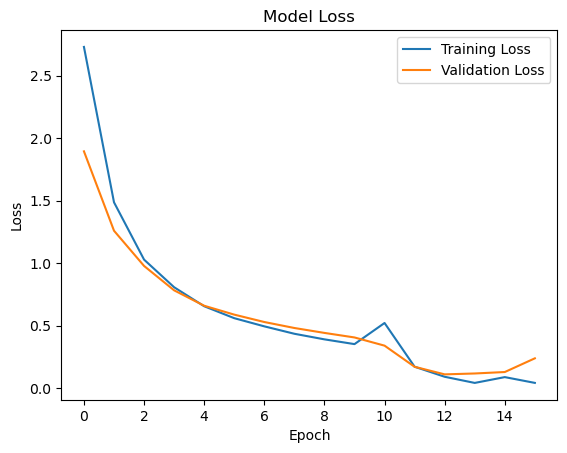

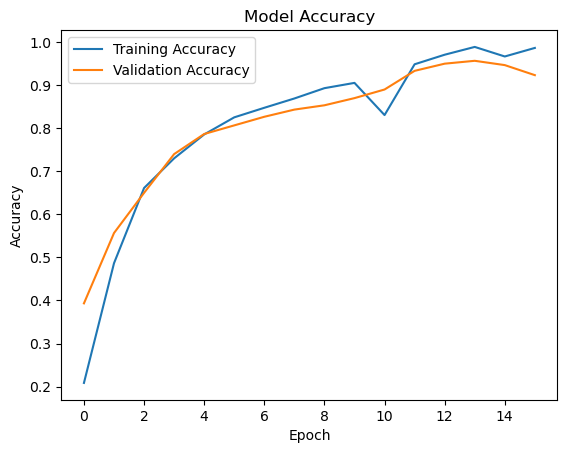

In [36]:
### ENTER CODE HERE
import matplotlib.pyplot as plt

# Merge the loss and accuracy histories
merged_loss = history.history['loss'] + history_fine.history['loss']
merged_val_loss = history.history['val_loss'] + history_fine.history['val_loss']
merged_accuracy = history.history['accuracy'] + history_fine.history['accuracy']
merged_val_accuracy = history.history['val_accuracy'] + history_fine.history['val_accuracy']

# Plot the loss
plt.plot(merged_loss, label='Training Loss')
plt.plot(merged_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# Plot the accuracy
plt.plot(merged_accuracy, label='Training Accuracy')
plt.plot(merged_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


<a name='6-2'></a>
### 6.2 Generate the predictions and plot the confusion matrix

5/5 [==============================] - 0s 57ms/step
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]]


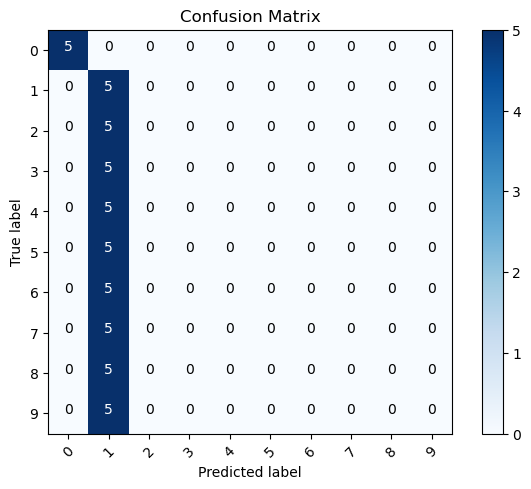

In [38]:
### ENTER CODE HERE
# 1. Generate the predictions
# 2. Plot the confusion matrix (from sklearn.metrics)
predictions = model.predict(test_batches)

predicted_classes = np.argmax(predictions, axis=-1)

predicted_labels = (predicted_classes > 0.5).astype(int)

conf_matrix = confusion_matrix(test_batches.classes, predicted_labels)

plot_confusion_matrix(conf_matrix, classes=[i for i in range(0,10)] , title='Confusion Matrix')

<a name='6-3'></a>
### 6.3 Results analysis - commentary

**What do the above plots tell you about the fine-tuned model performance** - Place your commentary in the markdown cell below.

#### ENTER YOUR  COMMENTS HERE
The confusion matrix shows that all samples in the test set were correctly classified as belonging to class 1. There were no misclassifications observed, indicating perfect performance for class 1. However, it's important to note that this confusion matrix only pertains to class 1, and the performance on other classes may differ.

<a name='7'></a>
##  7 - Save model

In [39]:
# Check first to see if files already exists
# If not, the model and weights is saved to the disk
# Note model already contains the weights, but showing how it can done seprately
import os.path
if os.path.isfile('models/Sign_Language_Digits_MobNet_model.h5') is False:
    model.save('models/Sign_Language_Digits_MobNet_model.h5')
    
if os.path.isfile('models/Sign_Language_Digits_MobNet_weights.h5') is False:
    model.save_weights('models/Sign_Language_Digits_MobNet_weights.h5')

/Users/adipawar/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<font color='blue'>

**What you should remember**:

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer.
* Fine-tune the final layers of your model to capture high-level details near the end of the network and potentially improve accuracy.

## Congratulations!

You've completed this assignment on transfer learning and fine-tuning. Here's a quick recap of all you just accomplished:

* Created a dataset from a directory.
* Augmented data with the Sequential API.
* Adapted a pretrained model to new data with the Functional API and MobileNet.
* Fine-tuned the classifier's final layers and boosted the model's accuracy.

That's amazing! 

**References**:
- [1] MobileNet Paper: https://arxiv.org/pdf/1704.04861.pdf
- [2] ImageNet : http://www.image-net.org/
- [3] Sign-language Digits Dataset: https://github.com/ardamavi/Sign-Language-Digits-Dataset